# **Needed Libraries**


In [195]:
# Data science 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Single cell 
import scanpy as sc
import anndata as ad
# Consider aesthetics
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['axes.axisbelow'] = True
plt.rcParams.update({'font.size': 17})
# Output control
import warnings
warnings.filterwarnings("ignore")
# Potting utils 
from utils.plotting import plot_pca

We load the file we saved from the preprocessing step:


In [196]:
adata = sc.read("processed_datasets/dataset1.h5ad")

---


# **Stage 2: Dimensionality Reduction**


In datasets with higher dimensions, there is often an increased presence of noise and redundancy. Thus when performing cell type clustering based on gene expression profiles in the next stage of the pipeline, not all genes are informative. In order to address this, we in can employ dimensionality reduction algorithms to further reduce the dimensions of single-cell RNa-seq datasets.
In our pipeline we allow the user to choose between Principal Componenent Analysis (PCA), Uniform Manifold Approximation and Projection for Dimension Reduction (UMAP) & t-distributed stochastic neighbor embedding (t-SNE).

## **PCA**

Calculates the covariance matrix of the features in the dataset and then its eigenvalues and eigenvectors. Finally it sorts them based on the value of their corresponding eigenvalue. Eigenvector / Principal componenets with larger eigenvalues carry more information about the variance present in the dataset. PCA is a linear transformation and thus can "miss" non-linear relationships between features in the dataset.


To implement the PCA transformation, we make use of the pca method in the `scnapy` preprocessing library. This method requires the adata object as input and employs the arpack solver to find the principal components, which is well-suited for sparse matrices containing numerous zero values, such as single-cell datasets. As discussed before using the identified highly variable genes is not advised, thus the parameter is set to False and all genes are considered. Finally we set the number of principal componenets to be calculated to a third of dimensions, this strikes a balance between efficiency


Upon executing the method, the adata object is enriched with additional metadata of the PCA outcome. These details can be utilized to determine the most suitable number of principal components (PCs).
Specifically:

- `adata.uns['pca']['variance']` $\rightarrow$ Is an array containing the eigenvalues of each of the PCs
- `adata.uns['pca']['variance']` $\rightarrow$ Is an array containing the cummulative variance explained from the PCs
- `adata.obsm['X_pca']` $\rightarrow$ Is a matrix containing the eigenvectors resulted from the PCA transformation


Its safe to assume the the number of principal componenets to retain will be less than half of the input dimensions for single cell data, for this reason we set the number of components of the PCA to `adata.X.shape[1]/2`


In [197]:
n_components = round(adata.X.shape[1]/2)
sc.pp.pca(adata, svd_solver='arpack',use_highly_variable=False, n_comps= n_components)
adata

AnnData object with n_obs × n_vars = 199 × 200
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

We have coded a function called `plot_pca` that utilizes `adata.obsm['X_pca']` to plot the first two PCs, labeled with their respective cummulative variance. As presented below.


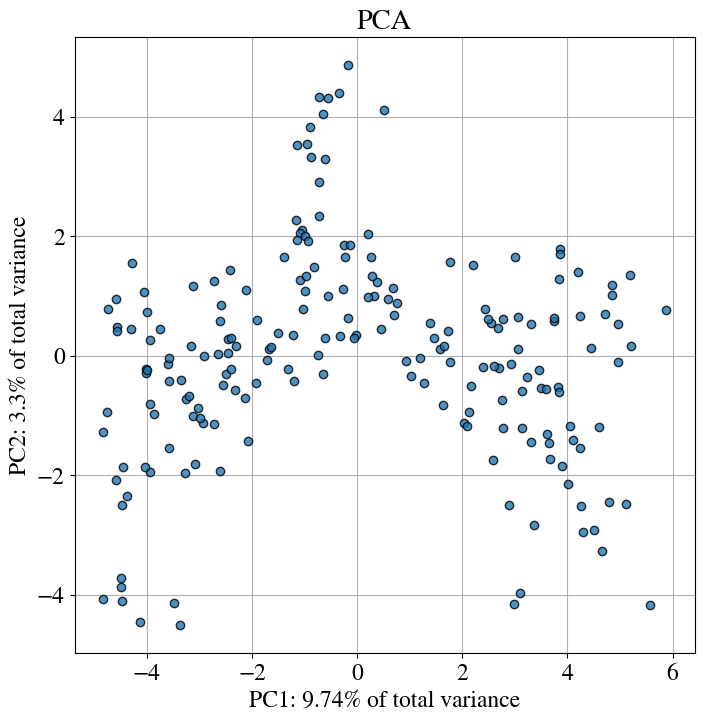

In [198]:
from utils.plotting import plot_pca
plot_pca(adata)

### _Selection the optimal number of components_

Various techniques can be employed to determine the optimal number of principal components. However, it is important to note that these methods often rely on subjective judgment.

#### 1. _Scree Plot_

One criterion involves analyzing a "Scree plot," which visually represents the number of principal components on the x-axis and their corresponding eigenvalues on the y-axis. By examining the plot, we can identify a point known as the "elbow," which indicates the principal component where the most significant change in curvature occurs. However, it is worth noting that the selection of this knee point is subjective since it relies on visual interpretation. An alternative approach is proposed in the research paper titled _"Finding a 'Kneedle' in a Haystack: Detecting Knee Points in System Behavior" by V. Satopaa, J. Albrecht, D. Irwin, and B. Raghavan (2011)_, available at [this link](https://ieeexplore.ieee.org/document/5961514). The paper presents a mathematical approach to identify knee points in an objective manner. A python implementation of the algorithm can be utilized via the `kneed` library.


Below the curve of the difference of normalized variance explained is illustrated, as you can see the knee points is the $2_{nd}$ Principal component:


Knee point is =  4


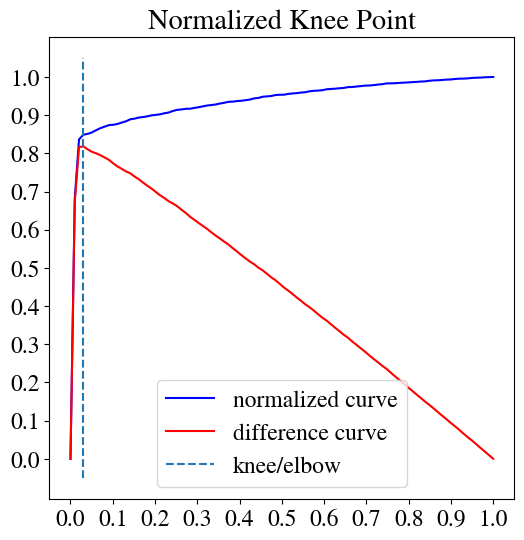

In [199]:
from kneed import KneeLocator
kneedle = KneeLocator(x =np.arange(1,adata.uns['pca']['variance'].shape[0]+1,1), y = adata.uns['pca']['variance'], S=1.0, curve="convex", direction="decreasing")
knee = round(kneedle.knee)
print("Knee point is = ", knee)
kneedle.plot_knee_normalized()

And the Scree plot representation follow below


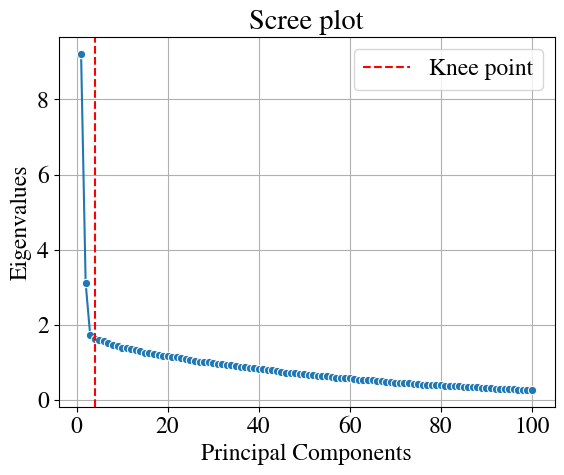

In [200]:
sns.lineplot(x = np.arange(1,adata.uns['pca']['variance'].shape[0]+1,1), y =adata.uns['pca']['variance'],marker='o')
plt.xlabel("Principal Components")
plt.axvline(x=knee, color = 'red',label = "Knee point",linestyle="dashed")
plt.ylabel("Eigenvalues")
plt.title("Scree plot")
plt.legend()
plt.grid()
plt.show()

#### 2._Variance Threshold_

Another criterion for determining the optimal number of principal components is to establish a threshold for the total variance explained by these components. Typically, this threshold falls within the range of 80% to 95%.
Below we showcase that 95 components are needed to retain $90\%$ of the variance


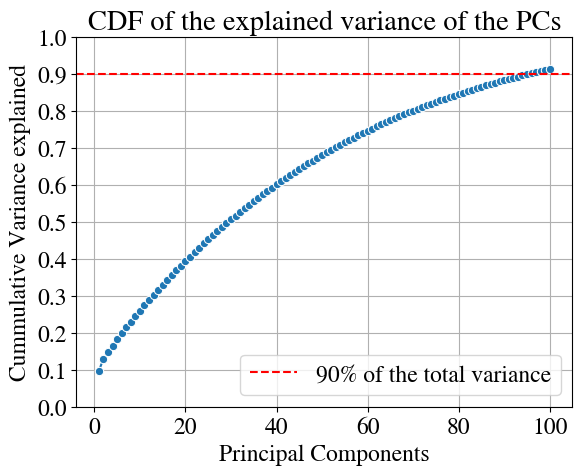

Variance Threshold of 90% keeps:  95 PCs


In [201]:
cummulative_variance = np.cumsum(adata.uns['pca']['variance_ratio'])
sns.lineplot(x = np.arange(1,adata.uns['pca']['variance'].shape[0]+1,1), y =cummulative_variance,marker='o')
plt.xlabel("Principal Components")
plt.axhline(y=0.90, color = 'red',label = "90% of the total variance",linestyle="dashed")
plt.ylabel("Cummulative Variance explained")
plt.title("CDF of the explained variance of the PCs")
plt.yticks(np.arange(0,1.1,0.1))
plt.legend()
plt.grid()
plt.show()
#Show the PCs kept with this method
print("Variance Threshold of 90% keeps: ",(cummulative_variance[cummulative_variance <= 0.90]).shape[0], "PCs")

#### 3. _Kaiser's Rule_

The Kaiser's rule, is another commonly employed technique for determining the optimal number of principal componenets to keep. The rule suggests that only principal components with variances greater than 1 should be kept. The rationale behind the Kaiser criterion is that any principal component with a variance below 1 carries less information than the original features, and therefore, it is not beneficial to retain them.


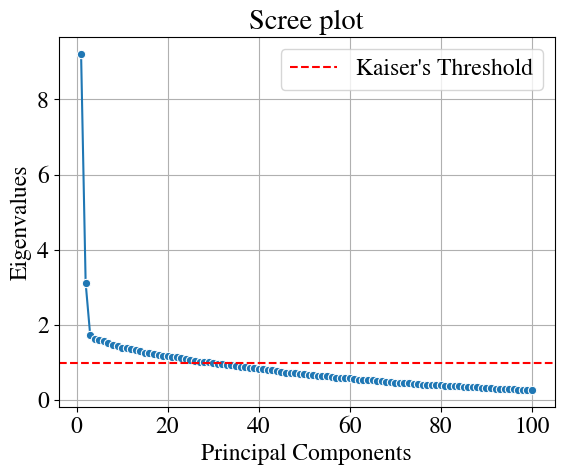

Kaiser's Threshold keeps:  29 PCs


In [202]:
sns.lineplot(x = np.arange(1,adata.uns['pca']['variance'].shape[0]+1,1), y =adata.uns['pca']['variance'],marker='o')
plt.xlabel("Principal Components")
plt.axhline(y= 1 , color = 'red',label = "Kaiser's Threshold",linestyle="dashed")
plt.ylabel("Eigenvalues")
plt.title("Scree plot")
plt.legend()
plt.grid()
plt.show()
print("Kaiser's Threshold keeps: ",(adata.uns['pca']['variance'][adata.uns['pca']['variance'] > 1]).shape[0], "PCs")

### Conclusion on the principal componenets selection method for PCA

Based on the aforementioned methods, we believe that the most effective approach for selecting the knee point is by identifying the principal component where the most substantial shift in curvature of variance, since it achieves an optimal trade-off between variance and bias without needing re-iterations and thus is well fitting in a pipeline setting. Nonetheless, recognizing that someone may prefer to establish their own threshold for variance and experiment with different analyses, we will incorporate the variance threshold criterion as an alternative in the final pipeline. Kaiser's rule wont be utilized since its constrain is not adaptive to each of the datasets.


## **T-SNE**


The t-SNE algorithm, also known as distributed stochastic neighbor embedding, is a powerful technique for embedding complex datasets with non-linear relationships in high dimensions into a low-dimensional 2-D space. However, it often prioritizes the preservation of local structures rather than the global structure, as explained. in the highly cited paper [The art of using t-SNE for single-cell transcriptomics](https://www.nature.com/articles/s41467-019-13056-x#Sec2).

The most important parameters and their suggested values for t-SNE are:

>

- **perplexity**: The attention between local and global aspects of the data, similar to the k neighbors we consider for each node in a graph.
  - Suggested values: $5 < \text{perplexity} < 50 < \text{dataset size}$ As proposed by its creator [Laurens van der Maaten](https://lvdmaaten.github.io/tsne/)
  - Suggested values: $\begin{cases} 30 + \text{dataset size}/100, & \text{for  }\text{dataset size}/100 > 30\\ 30, & else \end{cases}$ as suggested by the paper mentioned above
  - Increase: More attention to global structure
  - Decrease: More attention to local structure
    >
- **learning rate**: In t-SNE, the learning rate is a parameter that controls the step size during the optimization process. It determines how much the points move in each iteration of the algorithm
  - Suggested values: $\begin{cases}\text{dataset size}/12, & \text{for  }\text{dataset size} > 200 \\ 200, & \text{for  }\text{dataset size} <= 200\end{cases}$ as suggested by the paper mentioned above
  - Big increase: Points are aligned approximately equidistant from its nearest neighbours in a shape, variance is lost
  - Big Decrease: Points become compressed in a single cluster, variation is lost


Additionally in [The art of using t-SNE for single-cell transcriptomics](https://www.nature.com/articles/s41467-019-13056-x#Sec2) it is suggested to use only a few of the first PCs in the t-SNE PCA initialization to inject global structure into t-SNE. We utilize the optimal number as selected by the Scree plot.


We use the above information to create the `tsne_params` to calculate the suggested parameters in the pipeline implementation


In [203]:
def tsne_params(datasize):
  n = datasize/100
  if n/100 > 30:
    perplexity = 30 + n/100 
  else:
    perplexity = 30
  if datasize > 200:
    learning_rate = datasize/12
  else:
    learning_rate = 200
  return learning_rate, perplexity

Below we present the t-SNE 2D embedding.


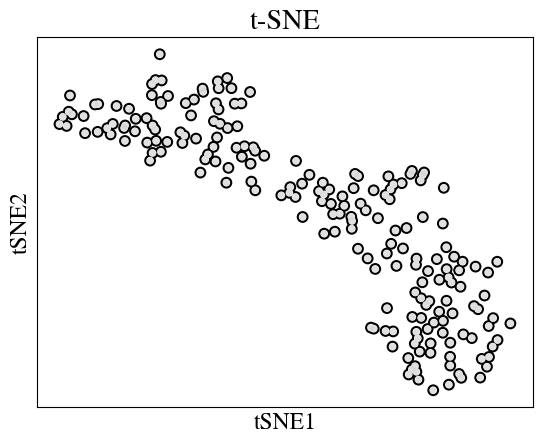

In [204]:
learning_rate, perplexity = tsne_params(adata.X.shape[0])
sc.tl.tsne(adata, n_pcs = knee, perplexity = perplexity, early_exaggeration=12, learning_rate = learning_rate, random_state=30, use_fast_tsne=False)
sc.pl.tsne(adata,add_outline = True, size = 100,title = "t-SNE")
plt.show()

The adata object is now enriched with the `X_tsne` representation


In [205]:
adata

AnnData object with n_obs × n_vars = 199 × 200
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'tsne'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'

## **UMAP**

Another non-linear


Finally having finished with dimensionality reduction we save the enriched with the PCA,t-SNA and UMAP representations `adata` object:


In [206]:
adata.write("processed_datasets/dataset1.h5ad")